# iT邦幫忙 - [[實戰系列] 使用 Keras 搭建一個 LSTM 魔法陣（模型）](https://ithelp.ithome.com.tw/articles/10206312)

## Step 1: 資料前處理

### Load Data

In [1]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd

# Import the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')  # 讀取訓練集
training_set = dataset_train.iloc[:, 1:2].values  # 取「Open」欄位值

### 做 Normalization，將資料壓縮在 [0,1] 之間

In [2]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### 準備進入訓練的資料格式：設定 Timestep
Timesteps 設為 60 ，代表過去 60 天的資訊，嘗試過數值設置太少，將使 RNN 無法學習。

In [3]:
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, 1258):  # 1258 是訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

### Reshape
因為現在 `X_train` 是 2-dimension，將它 reshape 成 3-dimension: `[stock prices, timesteps, indicators]`

In [4]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Step 2: 搭建一個 LSTM 魔法陣

### import Keras

In [5]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

Using TensorFlow backend.
/home/kk/jupyter/jupyter_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kk/jupyter/jupyter_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kk/jupyter/jupyter_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kk/jupyter/jupyter_env/lib/pytho

### 搭建 LSTM layer:
* `units`: 神經元的數目
* 第一層的 LSTM Layer 記得要設定 `input_shape` 參數
* 搭配使用 `dropout`，這裡設為 0.2
* 由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 `return_sequences` 設為預設值 False （也就是不用寫上 `return_sequences`）

In [6]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Ouput Layer: units 設為 1

In [7]:
# Adding the output layer
regressor.add(Dense(units = 1))

### Compiling & Fitting LSTM model
* `optimizer`: 選擇 Adam
* `loss`: 使用 MSE

In [14]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 進行訓練
regressor.fit(X_train, y_train, epochs = 100, batch_size = 64)

Epoch 1/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0075
Epoch 2/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0037
Epoch 3/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0033
Epoch 4/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0034
Epoch 5/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0035
Epoch 6/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0033
Epoch 7/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0038
Epoch 8/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0030
Epoch 9/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0031
Epoch 10/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0034
Epoch 11/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0032
Epoch 12/100
1198/1198 [==============================] - 5s 5ms/step - lo

## Step 3: 進行預測

### 取測試集中 2017 年的股票資料（真實）

In [15]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### 取模型所預測的 2017 年股票資料（預測）

In [16]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(60, 80):  # timesteps一樣60； 80 = 先前的60天資料+2017年的20天資料
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

### 進行預測

In [17]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # to get the original scale

### 視覺化結果

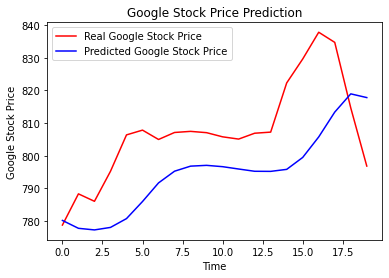

In [18]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')  # 紅線表示真實股價
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')  # 藍線表示預測股價
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

本次模型的任務是預測股票趨勢，由視覺化結果可以看出模型的預測表現，如預測的趨勢雖大致上跟真實股價是一致但預測的較為平滑。